# COMBINED ENSEMBLE MODEL

## Importing Necessary Packages

In [0]:
import matplotlib.pyplot as plt
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from nltk.stem.porter import *
import textstat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from gensim.models.keyedvectors import KeyedVectors
import re
import sys
import nltk
import seaborn
import numpy as np
import pandas as pd

# fix random seed for reproducibility
np.random.seed(21)

# Note tqdm import try
try:
    from tqdm.notebook import tqdm
except:
    import tqdm


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


## Loading the training data

In [0]:
X_train_davidson = pd.read_csv("hate_speech_labelled_data/labeled_data.csv")

X_train_davidson.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Columns key:

-   count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


-   hate_speech = number of CF users who judged the tweet to be hate speech.


-   offensive_language = number of CF users who judged the tweet to be offensive.


-   neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


-   class = class label for majority of CF users.

    -   0 - hate speech
    -   1 - offensive  language
    -   2 - neither

-   tweet = raw tweet text


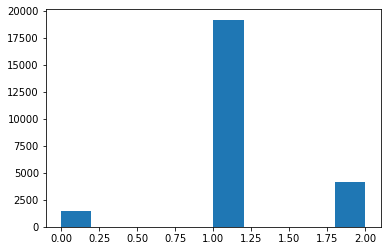

In [0]:
X_train_davidson['class'].hist(grid=False)

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

# Generate test, train splits for training and evaluating all models

In [0]:
X = X_train_davidson['tweet']
y = (X_train_davidson['class'].astype(int))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# NEURAL NETWORK

# Ensemble Neural Network *Implementation*

## Import required and custom modules

In [0]:
import util.nn_ensemble.evaluation as evaluation
import util.nn_ensemble.helper as helper
import util.nn_ensemble.nlp as nlp

## Model evaluation utility function

In [0]:
# Evaluation function
def generate_model_evaluations(y_preds, y_test):
    report = classification_report(y_test, y_preds)
    print(report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_preds)
    matrix_proportions = np.zeros((3, 3))

    for i in range(0, 3):
        matrix_proportions[i, :] = conf_matrix[i, :] / \
            float(conf_matrix[i, :].sum())

    names = ['Hate', 'Offensive', 'Neither']
    confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
    plt.figure(figsize=(5, 5))
    seaborn.heatmap(confusion_df, annot=True, annot_kws={
                    "size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
    plt.ylabel(r'True categories', fontsize=14)
    plt.xlabel(r'Predicted categories', fontsize=14)
    plt.tick_params(labelsize=12)

    fig, axes = plt.subplots(1, 2)
    fig.set_figwidth(10)

    axes[0].set_title('True Distribution')
    axes[1].set_title('Predicted Distribution')

    y.hist(bins=100, ax=axes[0], grid=False)
    pd.Series(y_preds).hist(bins=100, ax=axes[1], grid=False)

    # Uncomment to save the output
    # plt.savefig('confusion.pdf')

## Utility function

For preprocessing tweets for acquiring the word to vec embeddings

In [0]:
def get_cnn_embeddings(word_embeddings, tweets_tokenized, max_tokens=50):
    '''twitter embedding model only'''
    corpus_vecs = []
    for tweet in tweets_tokenized:
        tweet_vecs = [[0.0 for x in range(400)] for x in range(max_tokens)]
        for cnt, token in enumerate(tweet):
            try:
                tweet_vecs[cnt] = (word_embeddings[token].tolist())
            except:
                continue
        # tweet_vecs.append(embedding_sum/tweet_length)  # NOTE: L1 and High C 10+  better for this scenario
        # NOTE: L2 and Low C .01- better for this scenario
        corpus_vecs.append(tweet_vecs)
    return np.array(corpus_vecs)

## Defining CNN and Ensemble model classes

In [0]:
class CNN_model:

    def __init__(self,
                 input_size=50,
                 output_size=3,
                 loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'],
                 random_seed=87):
        self.input_size = input_size     # tokens
        self.output_size = output_size

        np.random.seed(random_seed)

        self.model = Sequential()
        self.model.add(Conv1D(filters=150, kernel_size=3,
                              padding='same', activation='relu',
                              input_shape=(input_size, 400)))
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Dense(250, activation='relu'))
        self.model.add(Dense(3, activation='sigmoid'))
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def fit(self, X_train, y_train,
            batch_size=32,
            epochs=3,
            validation_split=0.2,
            **kwargs):
        self.model.fit(X_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_split=validation_split,
                       **kwargs)

    def predict(self, X, verbose=0):
        return self.model.predict(X, verbose=verbose)

    def evaluate_model(self, y_test, y_pred):
        # output evaluation data
        print('--------- INDIVIDUAL CNN Model results ---------')
        print('--------- F-1/precision/recall report  ---------')
        print('---------         MACRO F1             ---------')
        print(f1_score(y_test, y_pred, average='macro'))
        print('---------         F1 Matrix            ---------')
        print(evaluation.evaluate_results(y_test, y_pred))

    def get_model_summary(self):
        return self.model.summary()

    def save_model(self, save_model_path):
        self.model.save(save_model_path)  # creates a HDF5 file 'my_model.h5'

    def load_model(self, load_model_path):
        self.model = load_model(load_model_path)


class Ensemble_CNN_model:

    def __init__(self,
                 load_weight_path=None,
                 num_ensemble_models=10,
                 input_size=50,
                 output_size=3,
                 random_seed=87):

        self.ensemble_cnns = [None]*num_ensemble_models

        for i in range(num_ensemble_models):
            np.random.seed(int(random_seed*(i+1)))
            self.ensemble_cnns[i] = CNN_model(input_size=input_size,
                                              output_size=output_size)
            if load_weight_path:
                try:
                    self.ensemble_cnns[i].load_model(load_weight_path+f'_{i}')
                except:
                    print(
                        f'Model weight not available: {load_weight_path}_{i}')

    def predict(self, X):
        aggregate_y_pred = []
        encoder = None

        RANGE = len(self.ensemble_cnns)
        for cnn_model in self.ensemble_cnns:
            y_soft_max = cnn_model.predict(X)
            y_pred = y_soft_max.argmax(axis=1)
            aggregate_y_pred.append(y_soft_max)

        # ADD ALL RESULTS
        sum_of_ys = aggregate_y_pred[0]
        for i in [x + 1 for x in range(RANGE - 1)]:
            sum_of_ys += aggregate_y_pred[i]

        # DIVIDE BY RANGE FOR MEAN
        sum_of_ys /= RANGE

        # ENCODE PREDS
        encoded_preds = sum_of_ys.argmax(axis=1)
        print(len(sum_of_ys), len(encoded_preds))
        return encoded_preds

    def fit_and_eval(self, X_train, y_train, X_test, y_test,
                     save_weight_path=None,
                     validation_split=0.2,
                     batch_size=32,
                     epochs=3,
                     **kwargs):
        aggregate_y_pred = []
        encoder = None

        RANGE = len(self.ensemble_cnns)
        for cnn_model in self.ensemble_cnns:
            y_encoder, y_one_hot = helper.one_hot_encode_y(y_train)
            cnn_model.fit(X_train, y_one_hot, epochs=epochs,
                          batch_size=batch_size)

            if save_weight_path:
                cnn_model.save_model(save_weight_path)

            y_soft_max = cnn_model.predict(X_test)
            encoded_preds = y_soft_max.argmax(axis=1)
            decoded_preds = y_encoder.inverse_transform(encoded_preds)

            cnn_model.evaluate_model(
                y_test, decoded_preds)  # print indv results
            aggregate_y_pred.append(y_soft_max)

        # ADD ALL RESULTS
        sum_of_ys = aggregate_y_pred[0]
        for i in [x + 1 for x in range(RANGE - 1)]:
            sum_of_ys += aggregate_y_pred[i]

        # DIVIDE BY RANGE FOR MEAN
        sum_of_ys /= RANGE

        # ENCODE PREDS
        encoded_preds = sum_of_ys.argmax(axis=1)
        decoded_preds = y_encoder.inverse_transform(encoded_preds)
        print(len(sum_of_ys), len(encoded_preds), len(decoded_preds))
        self.evaluate_model(y_test, decoded_preds)

    def evaluate_model(self, y_test, y_pred):
        print('--------- FINAL ENSEMBLE Model results ---------')
        print('---------  F-1/precision/recall report ---------')
        print('---------            MACRO F1:         ---------')
        print(f1_score(y_test, y_pred, average='macro'))
        print('---------            F1 Matrix         ---------')
        print(evaluation.evaluate_results(y_test, y_pred))

## Load the word vectors 

In [0]:
cnn_word_vectors = KeyedVectors.load_word2vec_format('pre_trained_models/word2vec_twitter_tokens.bin', 
                                                     binary=True,
                                                     unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Generating features from the train and test data
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = X_train, X_test, y_train, y_test

X_train_cnn = get_cnn_embeddings(cnn_word_vectors,
                                 map(lambda y: nlp.replace_tokens(y),
                                     nlp.tokenize_tweets(X_train_cnn,
                                                         lower_case=LOWER_CASE_TOKENS)),
                                 max_tokens=50)

X_test_cnn = get_cnn_embeddings(cnn_word_vectors,
                                map(lambda y: nlp.replace_tokens(y),
                                    nlp.tokenize_tweets(X_test_cnn,
                                                        lower_case=LOWER_CASE_TOKENS)),
                                max_tokens=50)
# Print out the shapes
print(X_train_cnn.shape, X_test_cnn.shape, y_train_cnn.shape, y_test_cnn.shape)

## Train the ensemble model

In [0]:
cnn_ensemble20 = Ensemble_CNN_model(random_seed=101, num_ensemble_models=20)

# Put more weight on the hate speech class
class_weight = {0: 3.,
                1: 1.,
                2: 1.}

cnn_ensemble20.fit_and_eval(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,
                            epochs=4, batch_size=32, class_weight=class_weight)

2479 2479
              precision    recall  f1-score   support

           0       0.66      0.33      0.44       147
           1       0.94      0.96      0.95      1937
           2       0.85      0.88      0.86       395

    accuracy                           0.91      2479
   macro avg       0.81      0.73      0.75      2479
weighted avg       0.91      0.91      0.91      2479



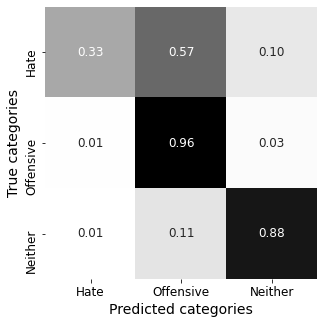

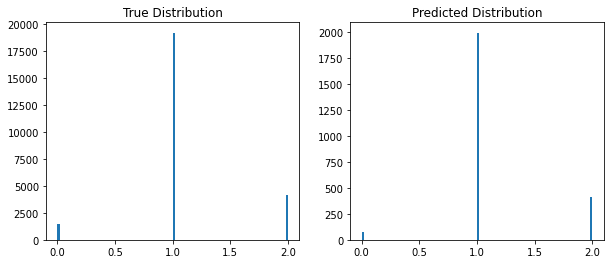

In [0]:
# Evaluate model
generate_model_evaluations(cnn_ensemble20.predict(X_test_cnn), y_test_cnn)

# DAVIDSON ET AL
# SUPPORT VECTOR MACHINE and LOGISTIC REGRESSION

## Utility Functions

In [0]:
from util.preprocess_log_regr_and_svm import preprocess
from util.preprocess_log_regr_and_svm import tokenize
from util.preprocess_log_regr_and_svm import basic_tokenize
from util.preprocess_log_regr_and_svm import count_twitter_objs
from util.preprocess_log_regr_and_svm import other_features
from util.preprocess_log_regr_and_svm import get_feature_array
from util.preprocess_log_regr_and_svm import generate_features_train_data
from util.preprocess_log_regr_and_svm import generate_features_test_data

## Generate features for training SVC and LogReg

In [0]:
''' Alternative generation, use train data only for vectorizer and pos_vectorizer generation '''
X_train_sl, X_test_sl, y_train_sl, y_test_sl = X_train, X_test, y_train, y_test

# Generate features from X_train_sl and X_test_sl
X_train_sl, vectorizer, pos_vectorizer = generate_features_train_data(X_train_sl)
X_test_sl = generate_features_test_data(X_test_sl, vectorizer, pos_vectorizer)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Train SVC classifier

In [0]:
svc_pipe = Pipeline(
    [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                   penalty="l1",
                                                   C=0.01,
                                                   solver='liblinear'))),
        ('model', LinearSVC(class_weight='balanced', C=0.01, penalty='l2',
                            loss='squared_hinge', multi_class='ovr',
                            dual=False, max_iter=10000))])

# Optionally add parameters here
svc_param_grid = [{}]
svc_grid_search = GridSearchCV(svc_pipe,
                               svc_param_grid,
                               cv=StratifiedKFold(n_splits=5, shuffle=True).split(
                                   X_train, y_train),
                               verbose=2)

# Train model and optimize with grid search
svc_model = svc_grid_search.fit(X_train_sl, y_train_sl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ................................................. , total=   3.3s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   4.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s finished


## Evaluating the results

              precision    recall  f1-score   support

           0       0.46      0.60      0.52       164
           1       0.96      0.91      0.94      1905
           2       0.82      0.95      0.88       410

    accuracy                           0.89      2479
   macro avg       0.75      0.82      0.78      2479
weighted avg       0.91      0.89      0.90      2479



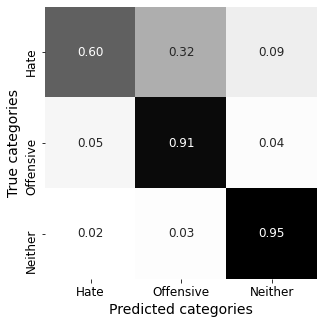

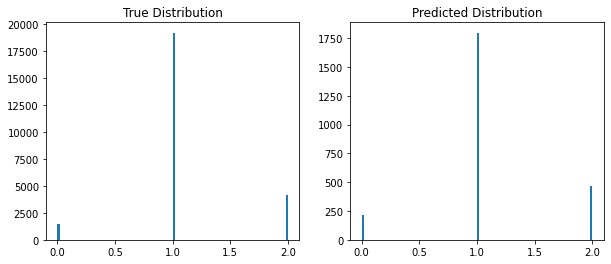

In [0]:
generate_model_evaluations(svc_model.predict(X_test_sl), y_test_sl)

## Train Logistic Regression classifier

In [0]:
logreg_pipe = Pipeline(
    [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                   penalty="l1",
                                                   C=0.01,
                                                   solver='liblinear'))),
     ('model', LogisticRegression(class_weight='balanced', penalty='l2'))])

logreg_param_grid = [{}]  # Optionally add parameters here
logreg_grid_search = GridSearchCV(logreg_pipe,
                                  logreg_param_grid,
                                  cv=StratifiedKFold(n_splits=5, random_state=42).split(
                                      X_train, y_train),
                                  verbose=2)

# Train model and optimize with grid search
logreg_model = logreg_grid_search.fit(X_train_sl, y_train_sl)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.8s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................................................. , total=   4.5s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................................................. , total=   4.9s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................................................. , total=   4.8s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished


[CV] ................................................. , total=   4.5s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Evaluating the Results

              precision    recall  f1-score   support

           0       0.31      0.71      0.43       164
           1       0.97      0.83      0.89      1905
           2       0.77      0.92      0.84       410

    accuracy                           0.83      2479
   macro avg       0.68      0.82      0.72      2479
weighted avg       0.90      0.83      0.85      2479



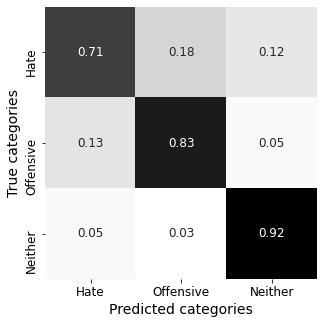

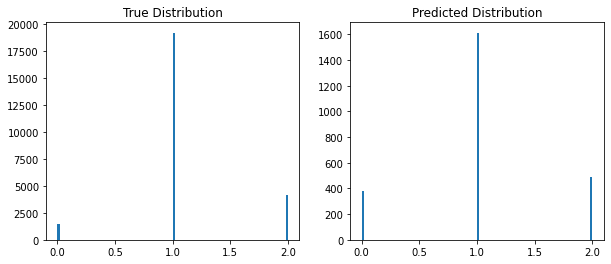

In [0]:
generate_model_evaluations(logreg_model.predict(X_test_sl), y_test_sl)

--------
# COMBINED ENSEMBLE

## Combined Ensemble Class

In [0]:
class CombinedMiniEnsemble:

    def __init__(self, logreg_model,
                 svc_model):
        self.logreg_model = logreg_model
        self.svc_model = svc_model

    def predict(self, X, vectorizer, pos_vectorizer):
        X_m_1_2 = generate_features_test_data(X, vectorizer, pos_vectorizer)

        y_m1 = self.logreg_model.predict(X_m_1_2)
        y_m2 = self.svc_model.predict(X_m_1_2)

        return np.array([np.bincount(arr).argmax() for arr in np.vstack((y_m1, y_m2)).T])

In [0]:
# Create the combined mini ensemble model
mini_comb1 = CombinedMiniEnsemble(logreg_model, svc_model)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)



              precision    recall  f1-score   support

           0       0.31      0.74      0.44       164
           1       0.97      0.84      0.90      1905
           2       0.84      0.90      0.87       410

    accuracy                           0.84      2479
   macro avg       0.71      0.83      0.74      2479
weighted avg       0.91      0.84      0.87      2479



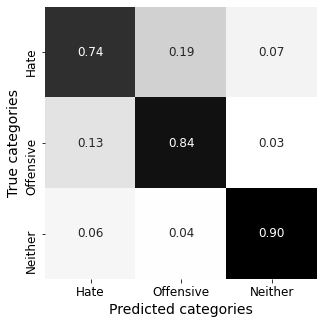

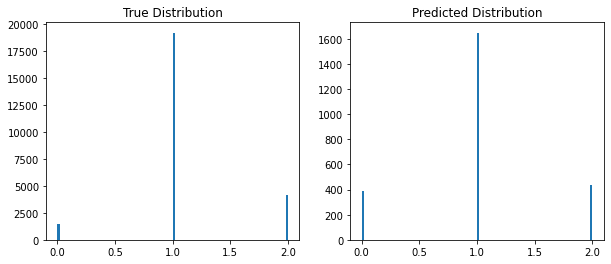

In [0]:
# Test combined ensemble on Davidson test data
generate_model_evaluations(mini_comb1.predict(X_test, vectorizer, pos_vectorizer), y_test)

In [0]:
class CombinedEnsemble:

    def __init__(self, nn_ensemble_model,
                 logreg_model,
                 svc_model):
        self.nn_ensemble_model = nn_ensemble_model
        self.logreg_model = logreg_model
        self.svc_model = svc_model

    def predict(self, X, word_vectors, vectorizer, pos_vectorizer):
        X_m1 = get_cnn_embeddings(word_vectors,
                                  map(lambda y: nlp.replace_tokens(y),
                                      nlp.tokenize_tweets(X,
                                                          lower_case=LOWER_CASE_TOKENS)), max_tokens=50)
        X_m_2_3 = generate_features_test_data(X, vectorizer, pos_vectorizer)

        y_m1 = self.nn_ensemble_model.predict(X_m1)
        y_m2 = self.logreg_model.predict(X_m_2_3)
        y_m3 = self.svc_model.predict(X_m_2_3)

        return np.array([np.bincount(arr).argmax() for arr in np.vstack((y_m1, y_m2, y_m3)).T])

In [0]:
# Create the combined ensemble model
comb1 = CombinedEnsemble(cnn_ensemble20, logreg_model, svc_model)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)



2479 2479
              precision    recall  f1-score   support

           0       0.50      0.70      0.58       164
           1       0.98      0.91      0.94      1905
           2       0.84      0.96      0.90       410

    accuracy                           0.91      2479
   macro avg       0.77      0.86      0.81      2479
weighted avg       0.92      0.91      0.91      2479



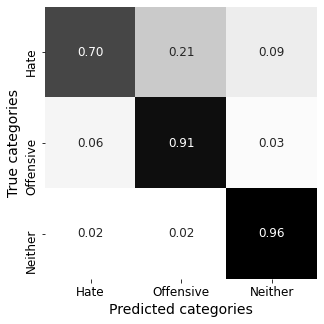

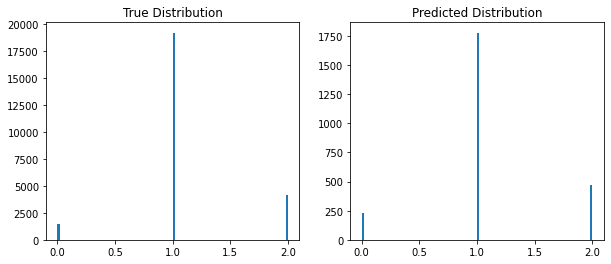

In [0]:
# Test combined ensemble on Davidson test data
generate_model_evaluations(comb1.predict(X_test, cnn_word_vectors, vectorizer, pos_vectorizer), y_test)